In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [15]:
class State:

    def __init__(self, n1, n2, n3, n4=None):

        self.player_current_sum = n1
        self.dealer_showing_card = n2
        self.player_usable_ace = n3
        self.action = n4

In [16]:
class BlackJack:

    def __init__(self):

        self.dealer_policy = dict()
        for i in range(17):
            self.dealer_policy[i] = "hit"
        for i in range(17, 22):
            self.dealer_policy[i] = "stick"
        player_usable_ace = bool(np.random.choice([0, 1]))
        player_current_sum = np.random.randint(12, 22)
        dealer_showing_card = np.random.randint(1, 11)
        self.initial_state = State(player_current_sum, dealer_showing_card, player_usable_ace)
        self.initial_state.action = np.random.choice(["hit", "stick"])
        self.dealer_current_sum = 0
        self.dealer_usable_ace = False
        self.dealer_not_showing_card = self.hit()
        if dealer_showing_card == 1 and self.dealer_not_showing_card == 1:
            self.dealer_usable_ace = True
            self.dealer_current_sum = 12
        elif dealer_showing_card == 1:
            self.dealer_usable_ace = True
            self.dealer_current_sum = 11 + self.dealer_not_showing_card
        elif self.dealer_not_showing_card == 1:
            self.dealer_usable_ace = True
            self.dealer_current_sum = 11 + dealer_showing_card
        else:
            self.dealer_usable_ace = False
            self.dealer_current_sum = dealer_showing_card + self.dealer_not_showing_card

    def hit(self):

        card = np.random.randint(1, 14)
        return min(10, card)

    def player_policy(self, i, state_value, state_count, current_state):

        if i == 0:
            if current_state.player_current_sum <= 19:
                return "hit"
            return "stick"
        else:
            idx_1 = current_state.player_current_sum - 12
            idx_2 = current_state.dealer_showing_card - 1
            if current_state.player_usable_ace:
                sv = state_value[0, idx_1, idx_2, :] / state_count[0, idx_1, idx_2, :]
            else:
                sv = state_value[1, idx_1, idx_2, :] / state_count[1, idx_1, idx_2, :]
            max_state_value = np.max(sv)
            optimal_actions = list()
            for a in range(sv.shape[0]):
                if sv[a] == max_state_value:
                    optimal_actions.append(a)
            action = np.random.choice(optimal_actions)
            if action == 0:
                return "hit"
            elif action == 1:
                return "stick"
            return None

    def play_game(self, i, state_value, state_count):

        episode = list()
        current_state = self.initial_state

        while True:
            if current_state.action is None:
                current_state.action = self.player_policy(i, state_value, state_count, current_state)
            episode.append([current_state, current_state.action])
            player_current_sum = current_state.player_current_sum
            player_usable_ace = current_state.player_usable_ace

            if current_state.action == "hit":
                card = self.hit()
                if card == 1:
                    if current_state.player_usable_ace:
                        ace_count = 1
                    else:
                        ace_count = 0
                    ace_count += 1
                    player_current_sum = player_current_sum + 11
                    while player_current_sum > 21 and ace_count:
                        player_current_sum = player_current_sum - 10
                        ace_count -= 1
                    if player_current_sum > 21:
                        return episode, -1
                    if ace_count == 1:
                        player_usable_ace = True
                    else:
                        player_usable_ace = False
                else:
                    player_current_sum = current_state.player_current_sum + card
                if player_current_sum > 21 and player_usable_ace:
                    player_current_sum = player_current_sum - 10
                    player_usable_ace = False
                elif player_current_sum > 21:
                    return episode, -1
            else:
                break
            current_state = State(player_current_sum, current_state.dealer_showing_card, player_usable_ace)

        while True:
            dealer_action = self.dealer_policy[self.dealer_current_sum]
            if dealer_action == "hit":
                card = self.hit()
                if card == 1:
                    ace_count = 0
                    if self.dealer_usable_ace:
                        ace_count = 1
                    ace_count += 1
                    self.dealer_current_sum += 11
                    while self.dealer_current_sum > 21 and ace_count:
                        self.dealer_current_sum -= 10
                        ace_count -= 1
                    if self.dealer_current_sum > 21:
                        return episode, 1
                    if ace_count == 1:
                        self.dealer_usable_ace = True
                    else:
                        self.dealer_usable_ace = False
                else:
                    self.dealer_current_sum += card
                if self.dealer_current_sum > 21 and self.dealer_usable_ace:
                    self.dealer_current_sum = self.dealer_current_sum - 10
                    self.dealer_usable_ace = False
                elif self.dealer_current_sum > 21:
                    return episode, 1
            else:
                break

        if current_state.player_current_sum > self.dealer_current_sum:
            return episode, 1
        elif current_state.player_current_sum == self.dealer_current_sum:
            return episode, 0
        else:
            return episode, -1
        

In [17]:
class MonteCarloControlES:

    def __init__(self,n):
        self.no_of_episodes = n
        self.state_action_values = np.zeros((2, 10, 10, 2))
        self.state_action_count = np.ones((2, 10, 10, 2))

    def exploring_starts(self):

        for i in range(self.no_of_episodes):
            black_jack_obj = BlackJack()
            episode, reward = black_jack_obj.play_game(i,self.state_action_values, self.state_action_count)
            t = len(episode) - 1
            while t >= 0:
                s_t = episode[t][0]
                a_t = episode[t][1]
                if a_t == "hit":
                    a_t = 0
                elif a_t == "stick":
                    a_t = 1
                index_player_sum = s_t.player_current_sum - 12
                index_dealer_showing_card = s_t.dealer_showing_card - 1
                if s_t.player_usable_ace:
                    index_usable_ace = 0
                else:
                    index_usable_ace = 1
                self.state_action_values[index_usable_ace, index_player_sum, index_dealer_showing_card, a_t] += reward
                self.state_action_count[index_usable_ace, index_player_sum, index_dealer_showing_card, a_t] += 1
                t = t - 1
        return self.state_action_values/self.state_action_count

In [18]:
def plot_fig_5_2():
    mc_obj = MonteCarloControlES(500000)
    state_action_values = mc_obj.exploring_starts()
    usable_ace_state_values = np.max(state_action_values[0, :, :, :], axis=-1)
    no_usable_ace_state_values = np.max(state_action_values[1, :, :, :], axis=-1)
    optimal_policy_usable_ace = np.argmax(state_action_values[0, :, :, :], axis=-1)
    optimal_policy_no_usable_ace = np.argmax(state_action_values[1, :, :, :], axis=-1)

    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(222, projection='3d')
    X = np.arange(10)
    Y = np.arange(10)
    X, Y = np.meshgrid(X, Y)
    ax.plot_surface(X, Y, usable_ace_state_values, cmap="hot")
    ax.set_title("Usable ace V*")
    ax.set_ylabel("Player sum")
    ax.set_xlabel("Dealer showing")
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

    ax = fig.add_subplot(224, projection = '3d')
    ax.plot_surface(X,Y, no_usable_ace_state_values, cmap="hot")
    ax.set_title("No usable ace V*")
    ax.set_ylabel("Player sum")
    ax.set_xlabel("Dealer showing")
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

    ax = fig.add_subplot(221)
    ax.imshow(np.flipud(optimal_policy_usable_ace))
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [21, 20, 19, 18, 17, 16, 15, 14, 13, 12])
    ax.set_title("Usable ace P*")
    ax.set_ylabel("Player sum")
    ax.set_xlabel("Dealer showing")

    ax = fig.add_subplot(223)
    ax.imshow(np.flipud(optimal_policy_no_usable_ace))
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [21, 20, 19, 18, 17, 16, 15, 14, 13, 12])
    ax.set_title("No usable ace P*")
    ax.set_ylabel("Player sum")
    ax.set_xlabel("Dealer showing")
    plt.savefig('figure_5_2.png')
    plt.show()
    plt.close()

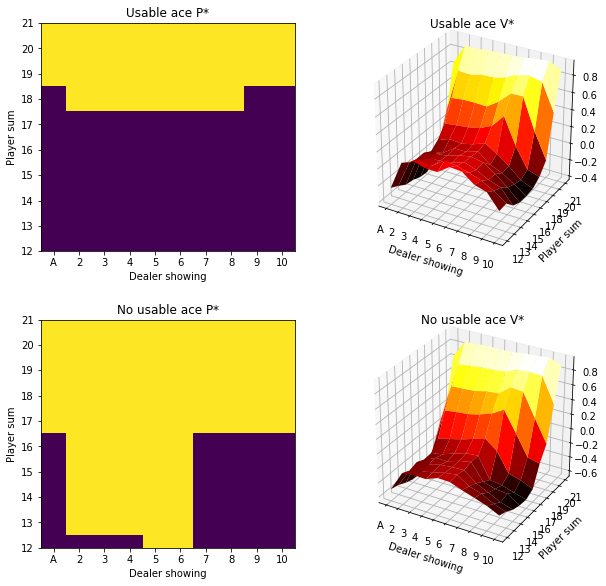

In [19]:
plot_fig_5_2()